In [1]:
from writers import foyer_xml_writer
from writers.foyer_xml_writer import parmed_to_foyer_xml, mbuild_to_foyer_xml


import ele
import espaloma as esp
import forcefield_utilities as ffutils
import foyer
import gmso
import mbuild as mb
from mbuild.lib.recipes import Polymer
from mbuild.formats.hoomd_forcefield import create_hoomd_forcefield
import numpy as np
from openff.toolkit.topology import Molecule
from openff.toolkit.topology import Topology
import torch
from mbuild.formats.hoomd_forcefield import create_hoomd_forcefield
import hoomd
import gsd.hoomd
import matplotlib.pyplot as plt

import os
import warnings
warnings.filterwarnings("ignore")

if not os.path.exists("espaloma_model.pt"):
    os.system("wget http://data.wangyq.net/espaloma_model.pt")

/Users/madilyn/miniconda3/envs/espaloma/lib/python3.9/site-packages/qcelemental/models/results.py:788: DeprecationWarning: ResultProtocols has been renamed to AtomicResultProtocols and will be removed as soon as v0.13.0
  warn(
/Users/madilyn/miniconda3/envs/espaloma/lib/python3.9/site-packages/qcelemental/models/results.py:788: DeprecationWarning: ResultProtocols has been renamed to AtomicResultProtocols and will be removed as soon as v0.13.0
  warn(
LICENSE: Could not open license file "oe_license.txt" in local directory
LICENSE: N.B. OE_LICENSE environment variable is not set
LICENSE: N.B. OE_DIR environment variable is not set
LICENSE: No product keys!
LICENSE: No product keys!
LICENSE: No product keys!
LICENSE: No product keys!


In [42]:
import mbuild as mb
from openff.toolkit.topology import Molecule
import random
import numpy
import random
import warnings
warnings.filterwarnings("ignore")

octet = {6 : 4, 7 : 3,1 : 1,8 : 2,16 : 2, 9:1}
atom_type = {6:"C",7:"N",8:"O",1:"H",16:"S",9:"F"}

class MadAtom():
    
    def check_happy(self):
        if self.desired_order == self.current_order:
            self.happy = True
            return
        self.happy= False
    
    def add_order(self,o):
        self.current_order += o
        self.check_happy()
        for b in self.bonds:
            b.check_done()
    
    def status(self):
        return self.desired_order - self.current_order
    
    def __str__(self):
        return "{}{}: {}-{}, {}".format(atom_type[self.atomic_number],self.index,self.desired_order,self.current_order,self.happy)
    
    def __init__(self, i, an, do, co ):
        self.index = i
        self.atomic_number = an
        self.desired_order = do 
        self.current_order = co
        self.happy = False
        self.check_happy()
        self.bonds = []

class MadBond():
    def __init__(self,a1,a2,bo,i):
        self.atom1 = a1
        self.atom2 = a2
        self.order = bo
        self.happy = False
        self.index = i
        
    def __repr__(self):
        return "Bond {} {}{}-{}{} O={}, {}. ".format(self.index,atom_type[self.atom1.atomic_number],self.atom1.index,atom_type[self.atom2.atomic_number],self.atom2.index,self.order,self.happy)
    
    def check_done(self):
        if self.atom1.atomic_number == 1:
            self.happy = True
            return
        if self.atom2.atomic_number == 1:
            self.happy = True
            return
        if self.atom1.happy and self.atom2.happy:
            self.happy = True
            return
        self.happy = False
    
    def add_order(self,o):
        self.order += o
        self.atom1.add_order(o)
        self.atom2.add_order(o)
        self.check_done()
        
class BondWalker():

    def __init__(self, mol):
        self.mol = mol
        self.atom_list = []
        for atom in mol.atoms:
            self.atom_list.append(MadAtom(atom.molecule_atom_index, atom.atomic_number, octet[atom.atomic_number], len([b for b in mol.bonds if atom.molecule_atom_index in [b.atom1_index,b.atom2_index]]) )) #assumes we have no double bonds at the start
        self.bond_list = [MadBond(self.atom_list[b.atom1_index],self.atom_list[b.atom2_index],b.bond_order,i) for i,b in enumerate(mol.bonds)] # .bond_order inside each of these, and can use atom1_index atom2_index
        for b in self.bond_list: 
            b.atom1.bonds.append(b)
            b.atom2.bonds.append(b)
            b.check_done()
            
    def done(self):
        for i in self.atom_list:
            if i.happy == False:
                return False
        for i in self.bond_list:
            if i.happy == False:
                return False
        return True
    
    def bond_increasable(self, b):
        if not b.atom1.happy and not b.atom2.happy:
            if b.atom1.status() > 0:
                if b.atom2.status() >0:
                    b.add_order(1) #this triggers each atom to increment, and *their* bonds to check happiness
                    if self.done():
                        return True
                    for a in self.atom_list:
                        if a.happy == False:
                            for bx in a.bonds:
                                if self.bond_increasable(bx):
                                    return True
                            #no bonds around this unhappy atom "a" are increasable
                            b.add_order(-1)
                            return False
                        
    def fill_in_bonds(self):        
        for a in self.atom_list: #since some of the unhappy bonds might end up being OK, let's iterate atoms
            if a.happy == False:
                for b in a.bonds: #try incrementing every bond around every unhappy atom
                    if self.bond_increasable(b):
                        print("Done!")
                        for b1,b2 in zip(self.bond_list, self.mol.bonds):
                            b2.bond_order=b1.order 
                        return self.mol
        print("Sorry- I couldn't solve this")

Done!


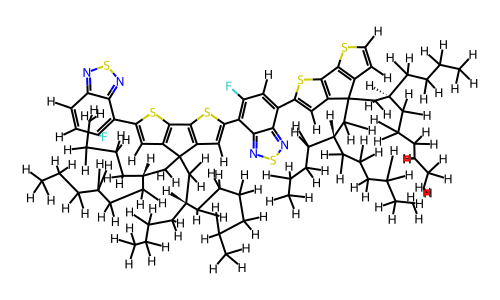

In [43]:
#thiophene = mb.load("c1ccsc1",smiles=True)
#thiophene.save("thio.sdf",overwrite=True)
b= BondWalker(Molecule.from_file("/Users/madilyn/Projects/repos/forcefields/PCPDTFBT_C1_BO.sdf",file_format = "sdf"))
compound = b.fill_in_bonds()
compound.visualize()

In [44]:
#cant get the sdf file or mol file to work with N-S-N bonds, it works from smiles string though...
#either need to get smiles string directly from mol2 file or figure out how to get the 
#smiles string from the smi file into a usable format. 
#it worked to run openbabel and get the smile string from the smi file and then just 
#delete the brackets around the N's.

molecule = compound
#molecule = Molecule.from_file("pt.sdf",file_format = "sdf")

#molecule = Molecule.from_smiles("[CH]1C2=NSN=C2C=N[CH]1")

#[CH]1[C]2[N]S[N][C]2[CH][N][CH]1

molecule_graph = esp.Graph(molecule)
#either generate smiles string from the built fragments or get our fragments into a Molecule supported file format

espaloma_model = torch.load("espaloma_model.pt")
espaloma_model(molecule_graph.heterograph)
openmm_system = esp.graphs.deploy.openmm_system_from_graph(molecule_graph)

# Store the results for each in something more accessible
pair_forces = openmm_system.getForces()[1]
angle_forces = openmm_system.getForces()[3]
bond_forces = openmm_system.getForces()[2]
torsion_forces = openmm_system.getForces()[0]

In [45]:
# get a parmed structure from openmm 
import parmed as pmd
topology = molecule.to_topology()
openmm_topology = topology.to_openmm()

structure = pmd.openmm.load_topology(topology=openmm_topology, system=openmm_system)
structure.bonds.sort(key=lambda x: x.atom1.idx)

In [46]:
# step 1: how to get bond parameters

bond_parameters = {}

for bond in structure.bonds:
    bond_parameters[(bond.atom1.name, bond.atom2.name)] = {"k":[bond.type.k] , "l0":[bond.type.req]}
    
# step 2: get angle parameters

angle_parameters = {}

for angle in structure.angles:
    angle_parameters[(angle.atom1.name, angle.atom2.name,angle.atom3.name)] = {"k":[angle.type.k], 
                                                                               "t0":[angle.type.theteq]}
    
# step 3: dihedral parameters

dihedral_parameters = {}

for dihedral in structure.dihedrals:
    dihedral_parameters[(dihedral.atom1.name, dihedral.atom2.name,dihedral.atom3.name,
                         dihedral.atom4.name)] = {"periodicity":[dihedral.type.per],
                                                  "k":[dihedral.type.phi_k],"phase":[dihedral.type.phase]}
    
# step 4: non-bonding parameters

nonbonded_parameters = {}

for nonbonded in structure.adjusts:
    nonbonded_parameters[(nonbonded.atom1.name,nonbonded.atom2.name)] = {"sigma":[nonbonded.type.rmin],
                                                    "epsilon":[nonbonded.type.epsilon],
                                                    "charge":[nonbonded.type.chgscale]}

In [47]:
particle_types = []
particle_type_dict = dict()

for i in range(pair_forces.getNumParticles()):
    pair_parms = pair_forces.getParticleParameters(index=i)
    charge = pair_parms[0]
    sigma = pair_parms[1]
    epsilon = pair_parms[2]
    if (charge, sigma, epsilon) not in particle_types: #this is adding the charge,sigma, and epsilon to the particle_types, but only once.
        particle_types.append((charge, sigma, epsilon))
        #print((charge, sigma, epsilon) )
    particle_type_dict[i] = particle_types.index((charge, sigma, epsilon)) #adding only the index of the pair_parms, this gives particle types.
print(particle_type_dict)

#particle_types gives the sigma, charge, and epsilon associated with each unique particle, 
#particle_type_dict only gives the index associated with each unique particle type

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33, 34: 34, 35: 35, 36: 36, 37: 37, 38: 38, 39: 39, 40: 40, 41: 41, 42: 42, 43: 43, 44: 44, 45: 45, 46: 34, 47: 46, 48: 47, 49: 13, 50: 48, 51: 49, 52: 50, 53: 49, 54: 51, 55: 52, 56: 53, 57: 54, 58: 53, 59: 53, 60: 55, 61: 56, 62: 57, 63: 57, 64: 57, 65: 58, 66: 58, 67: 59, 68: 59, 69: 60, 70: 60, 71: 61, 72: 62, 73: 62, 74: 63, 75: 63, 76: 64, 77: 64, 78: 65, 79: 65, 80: 66, 81: 66, 82: 65, 83: 65, 84: 67, 85: 67, 86: 67, 87: 48, 88: 49, 89: 50, 90: 49, 91: 51, 92: 52, 93: 53, 94: 54, 95: 53, 96: 53, 97: 55, 98: 56, 99: 57, 100: 57, 101: 57, 102: 58, 103: 58, 104: 59, 105: 59, 106: 60, 107: 60, 108: 61, 109: 62, 110: 62, 111: 63, 112: 63, 113: 64, 114: 64, 115: 65, 116: 65, 117: 66, 118: 66, 119: 65, 120: 65, 121: 67, 122: 67, 123: 67, 124

In [48]:
#graph check
#want to check if the opemm and parmed graphs are the same so we can use types from parmed 
import networkx  as nx
Gopenmm = nx.Graph()
Gparmed = nx.Graph()
#openmm:
for i in range(bond_forces.getNumBonds()):
    Gopenmm.add_edge(bond_forces.getBondParameters(index=i)[0],bond_forces.getBondParameters(index=i)[1])
#parmed
for b in structure.bonds:
    Gparmed.add_edge(b.atom1.idx,b.atom2.idx)
type_map = {}
#nx.rooted_tree_isomorphism
#in here we still need to check that one known index on one corresponds to the same index on the other....
tree_openmm = nx.bfs_tree(Gopenmm,0)
tree_parmed = nx.bfs_tree(Gparmed,0)
if nx.is_isomorphic(Gopenmm,Gparmed):
#if nx.isomorphism.tree_isomorphism(tree_openmm,tree_parmed):  <- want this work
    for b in structure.bonds:
        type_map[b.atom1.idx] = b.atom1.atom_type.__str__()
        type_map[b.atom2.idx] = b.atom2.atom_type.__str__()
print(type_map)

{0: 'C1', 55: 'C1', 1: 'C2', 5: 'C2', 2: 'C2', 3: 'S1', 4: 'C2', 6: 'C2', 10: 'S1', 7: 'C2', 8: 'C2', 9: 'C2', 11: 'H1', 12: 'H2', 13: 'H2', 14: 'C1', 129: 'C1', 15: 'C2', 19: 'C2', 16: 'C2', 17: 'S1', 18: 'C2', 20: 'C2', 24: 'S1', 21: 'C2', 22: 'C2', 23: 'C2', 25: 'H2', 26: 'H2', 27: 'C2', 28: 'N1', 29: 'S1', 30: 'N1', 31: 'C2', 32: 'C2', 33: 'C2', 34: 'F1', 35: 'C2', 36: 'C2', 37: 'H2', 38: 'H2', 39: 'C2', 40: 'N1', 41: 'S1', 42: 'N1', 43: 'C2', 44: 'C2', 45: 'C2', 46: 'F1', 47: 'C2', 48: 'C2', 49: 'H2', 51: 'C1', 50: 'C1', 52: 'C1', 53: 'C1', 54: 'C1', 71: 'H3', 56: 'C1', 57: 'C1', 58: 'C1', 59: 'C1', 60: 'C1', 61: 'C1', 62: 'H3', 63: 'H3', 64: 'H3', 65: 'H3', 66: 'H3', 67: 'H3', 68: 'H3', 69: 'H3', 70: 'H3', 72: 'H3', 73: 'H3', 74: 'H3', 75: 'H3', 76: 'H3', 77: 'H3', 78: 'H3', 79: 'H3', 80: 'H3', 81: 'H3', 82: 'H3', 83: 'H3', 84: 'H3', 85: 'H3', 86: 'H3', 88: 'C1', 87: 'C1', 89: 'C1', 90: 'C1', 91: 'C1', 108: 'H3', 92: 'C1', 93: 'C1', 94: 'C1', 95: 'C1', 96: 'C1', 97: 'C1', 98: 'C1

In [50]:
# Rename the particle types so that they match the xml file
# This is needed when we aren't using SMARTS matching with Foyer.

monomer = mb.load("/Users/madilyn/Projects/repos/forcefields/PCPDTFBT_C1_BO.mol2")

for index in type_map:
    monomer[index].name = type_map[index]

In [51]:
bond_types = []
bond_dict = dict() #creating an empty dictionary to put our parameters in 

for i in range(bond_forces.getNumBonds()):
    bond_parms = bond_forces.getBondParameters(index=i)
    #print(bond_parms)
    #atoms = {(bond.atom1.name,bond.atom2.name):[]} #gives you the atom type name and index
    l0 = bond_parms[2]/bond_parms[2].unit
    k = bond_parms[3]/bond_parms[3].unit
    #if (type_map[bond_parms[0]],type_map[bond_parms[1]],k,l0) not in bond_dict:
    #    bond_types.append((type_map[bond_parms[0]],type_map[bond_parms[1]],k,l0))
    bond_dict[type_map[bond_parms[0]],type_map[bond_parms[1]]] = {'k':k,'l0':l0}
print(bond_dict)

{('C1', 'C2'): {'k': 86716.0287127931, 'l0': 0.15422515276117488}, ('C1', 'C1'): {'k': 258445.3753996953, 'l0': 0.15853296631183622}, ('C2', 'C2'): {'k': 51634.65355327713, 'l0': 0.13919137665100484}, ('C2', 'S1'): {'k': 11125.898392511885, 'l0': 0.20981636243317944}, ('S1', 'C2'): {'k': 11125.898392511885, 'l0': 0.20981636243317944}, ('C2', 'H1'): {'k': 234207.85232622953, 'l0': 0.1035506322053171}, ('C2', 'H2'): {'k': 79270.72433543637, 'l0': 0.10973517284345309}, ('C2', 'N1'): {'k': 43961.10373113416, 'l0': 0.14348880676630785}, ('N1', 'S1'): {'k': 12036.417769768952, 'l0': 0.21546097704924852}, ('S1', 'N1'): {'k': 12036.417769768952, 'l0': 0.21546097704924852}, ('N1', 'C2'): {'k': 44155.26673957616, 'l0': 0.14356849300898514}, ('C2', 'F1'): {'k': 15367.630138324845, 'l0': 0.15404129151758142}, ('C1', 'H3'): {'k': 367161.93461465, 'l0': 0.11570492903014223}}


In [52]:
angle_types = []
angle_dict = dict() #creating an empty dictionary to put our parameters in 

for i in range(angle_forces.getNumAngles()):
    angle_parms = angle_forces.getAngleParameters(index=i)
    k = angle_parms[4]/angle_parms[4].unit
    t0 = angle_parms[3]/angle_parms[3].unit  
#    if (type_map[angle_parms[0]],type_map[angle_parms[1]],type_map[angle_parms[2]],k,t0) not in angle_types:
#        angle_types.append((type_map[angle_parms[0]],type_map[angle_parms[1]],type_map[angle_parms[2]],k,t0))
    angle_dict[type_map[angle_parms[0]],type_map[angle_parms[1]],type_map[angle_parms[2]]] = {'k':k,'t0':t0}
print(angle_dict)

{('C1', 'C2', 'C2'): {'k': 420.320461090322, 't0': 2.261126756668091}, ('C1', 'C1', 'C1'): {'k': 248.14863751901606, 't0': 2.0357909202575684}, ('C1', 'C1', 'H3'): {'k': 261.4092978663944, 't0': 2.0663363933563232}, ('C2', 'C1', 'C2'): {'k': 411.99544021402534, 't0': 2.2507104873657227}, ('C2', 'C1', 'C1'): {'k': 282.68929158158954, 't0': 2.1995551586151123}, ('C2', 'C2', 'S1'): {'k': 432.3599363235145, 't0': 2.208003520965576}, ('C2', 'C2', 'C2'): {'k': 461.5559395811094, 't0': 2.010883331298828}, ('C2', 'C2', 'H2'): {'k': 524.0808991129775, 't0': 1.968165636062622}, ('C2', 'S1', 'C2'): {'k': 503.8939040242822, 't0': 1.7129753828048706}, ('S1', 'C2', 'C2'): {'k': 414.53514844983266, 't0': 2.171839952468872}, ('S1', 'C2', 'H1'): {'k': 546.9486799514723, 't0': 2.3533804416656494}, ('C2', 'C2', 'H1'): {'k': 586.2940483879075, 't0': 2.419590711593628}, ('C2', 'N1', 'S1'): {'k': 259.8218237270415, 't0': 2.1754252910614014}, ('C2', 'C2', 'N1'): {'k': 514.6628600486843, 't0': 2.2531223297119

In [53]:
dihedral_types = []
dihedral_dict = {}

for i in range(torsion_forces.getNumTorsions()):
    if i%6==0:
        periodicity=[]
        phase = []
        k = []
    dihedral_parms = torsion_forces.getTorsionParameters(index=i)
    periodicity.append(dihedral_parms[4])  
    phase.append( dihedral_parms[5]/dihedral_parms[5].unit)
    k.append(dihedral_parms[6]/dihedral_parms[6].unit)
#    if (type_map[dihedral_parms[0]],type_map[dihedral_parms[1]],type_map[dihedral_parms[2]],type_map[dihedral_parms[3]],periodicity,k,phase) not in dihedral_types:
#        dihedral_types.append((type_map[dihedral_parms[0]],type_map[dihedral_parms[1]],type_map[dihedral_parms[2]],
#        type_map[dihedral_parms[3]],periodicity,k,phase))
    dt = (type_map[dihedral_parms[0]],type_map[dihedral_parms[1]],type_map[dihedral_parms[2]],
                  type_map[dihedral_parms[3]])
   

    if periodicity[-1]==6:
        #print(dt,periodicity,phase)
        dihedral_dict[dt] = {'periodicity':periodicity,'k':k,'phase':phase}
print(dihedral_dict)

{('C1', 'C2', 'C2', 'S1'): {'periodicity': [1, 2, 3, 4, 5, 6], 'k': [2.669530553652402, 6.185397818936422, 0.4948080582964583, 0.7788996744514084, 2.5456647115436666, 0.14167536223426538], 'phase': [0.0, 3.141592653589793, 0.0, 0.0, 0.0, 0.0]}, ('C1', 'C2', 'C2', 'C2'): {'periodicity': [1, 2, 3, 4, 5, 6], 'k': [1.2892346707305833, 0.4844062324415802, 0.7115873418124776, 1.1816170967943127, 1.4763257152675233, 0.30649931059173974], 'phase': [3.141592653589793, 3.141592653589793, 3.141592653589793, 0.0, 3.141592653589793, 3.141592653589793]}, ('C1', 'C2', 'C2', 'H2'): {'periodicity': [1, 2, 3, 4, 5, 6], 'k': [1.4750908957901578, 3.331556398461465, 0.1262205572705237, 0.2467878420030883, 0.4206406436678352, 0.13277121346827134], 'phase': [0.0, 3.141592653589793, 3.141592653589793, 3.141592653589793, 3.141592653589793, 3.141592653589793]}, ('C1', 'C1', 'C1', 'C1'): {'periodicity': [1, 2, 3, 4, 5, 6], 'k': [0.6466810732640967, 0.9493915664693453, 0.4430385573562892, 0.8017279410666276, 2.84

In [54]:
nonbonded_types = []
nonbonded_dict = {}

for i in range(pair_forces.getNumParticles()):
    nonbonded_parms = pair_forces.getParticleParameters(index=i)
    charge = nonbonded_parms[0]/nonbonded_parms[0].unit
    sigma = nonbonded_parms[1]/nonbonded_parms[1].unit
    epsilon = nonbonded_parms[2]/nonbonded_parms[2].unit
    #atom_type = structure.adjusts.atom
    if (charge,sigma,epsilon) not in nonbonded_types:
        nonbonded_types.append((charge,sigma,epsilon))
    nonbonded_dict[(type_map[i])]={'charge':charge,'sigma':sigma,'epsilon':epsilon}
print(nonbonded_dict)

{'C1': {'charge': -0.09306465656565657, 'sigma': 0.3399669508423535, 'epsilon': 0.4577296}, 'C2': {'charge': 0.08503534343434344, 'sigma': 0.3399669508423535, 'epsilon': 0.359824}, 'S1': {'charge': 0.5570353434343435, 'sigma': 0.35635948725613575, 'epsilon': 1.046}, 'H1': {'charge': 0.17103534343434346, 'sigma': 0.2510552587719476, 'epsilon': 0.06276}, 'H2': {'charge': 0.16103534343434345, 'sigma': 0.25996424595335105, 'epsilon': 0.06276}, 'N1': {'charge': -0.3004646565656566, 'sigma': 0.3249998523775958, 'epsilon': 0.7112800000000001}, 'F1': {'charge': -0.12886465656565654, 'sigma': 0.3118145513491188, 'epsilon': 0.255224}, 'H3': {'charge': 0.032235343434343436, 'sigma': 0.2649532787749369, 'epsilon': 0.06568879999999999}}


In [55]:
# Save the forcefield XML file for future use, so that we don't have to repeat the espaloma process everytime
mbuild_to_foyer_xml(
    file_name="PCPDTFBT_C1_BO.xml",
    compound=monomer,
    bond_params=bond_dict,
    angle_params=angle_dict,
    dihedral_params=dihedral_dict,
    dihedral_type="periodic",
    non_bonded_params=nonbonded_dict,
    combining_rule="geometric",
    name="",
    version="",
    coulomb14scale=1.0,
    lj14scale=1.0)

# Save the mb.Compound with the new atom type names for future use.
monomer.save("PCPDTFBT_C1_BO_typed.mol2", overwrite=True)

## Workflow once we have created an XML file, and a typed mol2 file:

Everything above this cell is something that we should only need to do once.
Then, once we have an XML file, and a typed mol2 file (i.e. one with the particles renamed correctly)
every time we want to run a new simulation, the process would look like the cells below:

In [56]:
import mbuild as mb
import foyer
import hoomd
from mbuild.formats.hoomd_forcefield import create_hoomd_forcefield

In [57]:
esp_ff = foyer.Forcefield(forcefield_files="PCPDTFBT_C1_BO.xml")

In [58]:
# We have to add the underscore to the names manually if we are using foyer XML files without SMARTS definitions
mono = mb.load("PCPDTFBT_C1_BO_typed.mol2")
for p in mono.particles():
    p.name = f"_{p.name}"

In [71]:
box = mb.fill_box(compound=mono, n_compounds=5, box=[20,20,20])
box_pmd = esp_ff.apply(box)

In [61]:
snapshot, forcefield, refs = create_hoomd_forcefield(box_pmd, auto_scale=True, r_cut=2.5)

Processing LJ and QQ
Processing 1-4 interactions, adjusting neighborlist exclusions
Processing harmonic bonds
Processing harmonic angles
Processing periodic torsions


In [62]:
#setting cpu and simulation 
cpu = hoomd.device.CPU()
sim = hoomd.Simulation(device=cpu,seed=0)
sim.create_state_from_snapshot(snapshot)

In [65]:
#setting the integrator
kt = 1.2
free_particle = hoomd.filter.Tags(tags=[0,1])  #letting hoomd know which particles to update the positions of
integrator = hoomd.md.Integrator(dt = 0.01)
nvt = hoomd.md.methods.NVT(filter=hoomd.filter.All(), kT=1.2, tau=0.5) #what is tau?
integrator.forces = forcefield
integrator.methods.append(nvt)
sim.operations.integrator = integrator
sim.state.thermalize_particle_momenta(filter=free_particle, kT=kt)
# Set up GSD writer
gsd_writer = hoomd.write.GSD(
    trigger=hoomd.trigger.Periodic(int(2e2)),
    filename="traj_PCPDTFBT_C1_BO.gsd",  #name the output file
    mode="wb"
)
sim.operations.writers.append(gsd_writer)

In [70]:
sim.run(1e10)

**ERROR**: Particle with unique tag 439 is no longer in the simulation box.

Cartesian coordinates: 
x: 8.64534e+06 y: -730444 z: -469928
Fractional coordinates: 
f.x: 308085 f.y: -26029.6 f.z: -16745.8
Local box lo: (-14.0308, -14.0308, -14.0308)
          hi: (14.0308, 14.0308, 14.0308)


RuntimeError: Error computing cell list